In [125]:
import openmeteo_requests
from openmeteo_sdk.Variable import Variable
import pandas as pd
import numpy as np
from earthkit.plots.interactive import Chart, polar
import requests_cache
from retry_requests import retry
from earthkit.plots.interactive.charts import DEFAULT_LAYOUT
import copy
import plotly.graph_objects as go

Set up the API client and define the parameters to fetch the ECMWF ensemble forecast (ecmwf_ifs025) for Kloten Airport.

In [126]:
cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

url = "https://ensemble-api.open-meteo.com/v1/ensemble"
params = {
    "latitude": 47.4583,
    "longitude": 8.5480,
    "hourly": ["wind_direction_10m", "wind_speed_10m"],
    "models": "ecmwf_ifs025",
    "forecast_days": 1,
    # "wind_speed_unit": "kn"
}

responses = openmeteo.weather_api(url, params=params, verify=False)
response = responses[0]

# Print coordinates for verification
print(f"Coordinates: {response.Latitude():.2f}°N {response.Longitude():.2f}°E")
print(f"Elevation: {response.Elevation()} m asl")

Coordinates: 47.50°N 8.50°E
Elevation: 420.0 m asl


/home/pls/earthkit-plots/.venv/lib/python3.12/site-packages/urllib3/connectionpool.py:2299: InsecureRequestWarning:

Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3future.readthedocs.io/en/latest/advanced-usage.html#tls-warnings



Process the raw API response and organize the hourly data from all ensemble members into a structured pandas DataFrame.

In [127]:
hourly = response.Hourly()
hourly_variables = list(map(lambda i: hourly.Variables(i), range(0, hourly.VariablesLength())))
hourly_wind_direction_10m = filter(lambda x: x.Variable() == Variable.wind_direction and x.Altitude() == 10, hourly_variables)
hourly_wind_speed_10m = filter(lambda x: x.Variable() == Variable.wind_speed and x.Altitude() == 10, hourly_variables)

hourly_data = {"date": pd.date_range(
    start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
    end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
    freq=pd.Timedelta(seconds=hourly.Interval()),
    inclusive="left"
)}

for variable in hourly_wind_direction_10m:
    member = variable.EnsembleMember()
    hourly_data[f"wind_direction_10m_member{member}"] = variable.ValuesAsNumpy()
for variable in hourly_wind_speed_10m:
    member = variable.EnsembleMember()
    hourly_data[f"wind_speed_10m_member{member}"] = variable.ValuesAsNumpy()

hourly_dataframe = pd.DataFrame(data=hourly_data)

hourly_dataframe.head()

,date,wind_direction_10m_member0,wind_direction_10m_member1,wind_direction_10m_member2,wind_direction_10m_member3,wind_direction_10m_member4,wind_direction_10m_member5,wind_direction_10m_member6,wind_direction_10m_member7,wind_direction_10m_member8,...,wind_speed_10m_member41,wind_speed_10m_member42,wind_speed_10m_member43,wind_speed_10m_member44,wind_speed_10m_member45,wind_speed_10m_member46,wind_speed_10m_member47,wind_speed_10m_member48,wind_speed_10m_member49,wind_speed_10m_member50
0,2025-08-08 00:00:00+00:00,116.564987,90.0,116.564987,119.744789,135.000107,90.000000,90.000000,116.564987,116.564987,...,1.018234,1.297998,1.527351,0.804985,2.545584,0.509117,1.609969,1.609969,2.189795,1.297998
1,2025-08-08 01:00:00+00:00,123.690094,90.0,153.435013,128.659836,180.000000,90.000000,108.435043,135.000107,116.564987,...,0.509117,1.297998,1.018234,1.484318,2.305125,0.804985,1.527351,1.297998,2.189795,1.138420
2,2025-08-08 02:00:00+00:00,135.000107,90.0,153.435013,123.690094,180.000000,108.435043,153.435013,153.435013,116.564987,...,0.360000,0.804985,0.509117,2.160000,1.138420,1.138420,1.609969,1.018234,1.938659,1.440000
3,2025-08-08 03:00:00+00:00,153.435013,90.0,180.000000,153.435013,198.435043,135.000107,198.435043,180.000000,135.000107,...,0.509117,0.509117,0.720000,2.520000,0.720000,1.138420,1.835647,0.804985,1.527351,1.484318
4,2025-08-08 04:00:00+00:00,180.000000,270.0,224.999893,180.000000,213.690094,224.999893,216.869980,206.564987,135.000107,...,1.138420,0.509117,0.360000,2.545584,0.360000,0.804985,1.484318,1.138420,1.138420,1.938659


For our windrose plot, we only need the forecast for a single point in time. We'll select the data for the first hour and convert it into two NumPy arrays: one for wind speed and one for wind direction.

In [128]:
first_hour_data = hourly_dataframe.iloc[0]
wind_speed_api = first_hour_data.filter(like='wind_speed_10m').to_numpy()
wind_direction_api = first_hour_data.filter(like='wind_direction_10m').to_numpy()

print(f"Data prepared for plotting with {wind_speed_api.shape[0]} ensemble members.")

Data prepared for plotting with 51 ensemble members.


## Frequency Windrose

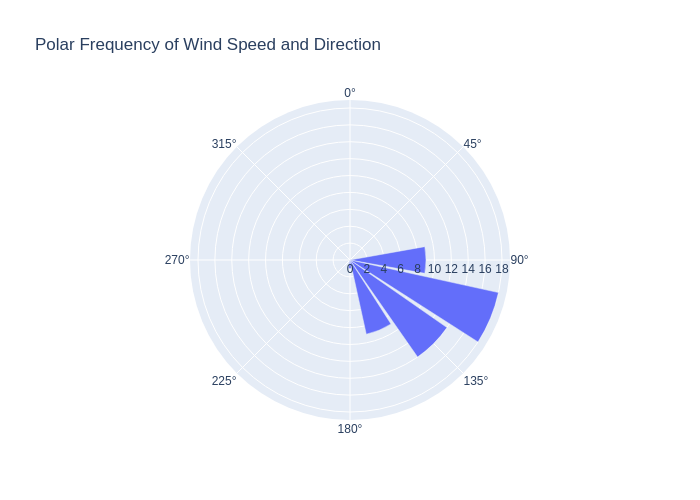

In [129]:
chart = Chart()

# Define the speed bins you want to see
speed_bins = [0, 5, 10, 15, 20, 25]

chart.polar_frequency(
    r=wind_speed_api,
    theta=wind_direction_api,
    radial_bins=speed_bins,
    n_angular_sectors=16
)

chart.title("Polar Frequency of Wind Speed and Direction")

chart.fig.update_layout(polar_barmode='stack')
chart.show(renderer="png")

## Special Windrose


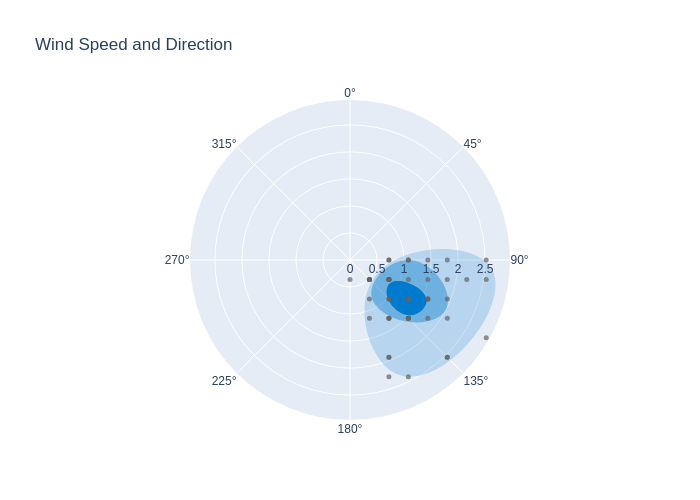

In [130]:
chart = Chart()

chart.polar(
    r=wind_speed_api.astype(np.float64),
    theta=wind_direction_api.astype(np.float64),
    show_ensemble_points=True,
    show_density_blobs=True,
    density_method="hybrid_vonmises",
)

chart.title("Wind Speed and Direction")

chart.show(renderer="png")

### Special Windrose use case: Hourly Windrose Forecast for Kloten Airport

We define the static elements (runways, colors) and then loops through the data to build the chart by adding all the graphical layers (blobs, circles, runways).

In [134]:
# Special elements
default_klo_runways = [
    {'angle1': 98, 'angle2': 278, 'name': 'KLO 10/28'},
    {'angle1': 137, 'angle2': 317, 'name': 'KLO 14/32'},
    {'angle1': 155, 'angle2': 335, 'name': 'KLO 16/34'}
]
runway_style = {"line": {"color": "rgba(128, 128, 128, 0.7)", "width": 6}}
blob_colors = [
    'rgba(54, 57, 102, 0.8)',
    'rgba(125, 77, 119, 0.8)',
    'rgba(255, 178, 109, 0.6)'
]

# Create the Chart object and main plotting loop
chart = Chart(rows=1, columns=6, specs=[[{"type": "polar"}] * 6])
subplot_titles = [t.strftime('%H:%M (UTC)') for t in hourly_dataframe["date"].head(6)]
chart._subplot_titles = subplot_titles

for i in range(6):
    row = hourly_dataframe.iloc[i+14]
    wind_speed = row.filter(like='wind_speed_10m').to_numpy()
    wind_direction = row.filter(like='wind_direction_10m').to_numpy()

    # Add windrose density blobs
    traces = polar.windrose(
        r=wind_speed.astype(np.float64),
        theta=wind_direction.astype(np.float64),
        colors=blob_colors,
        show_ensemble_points=False,
        show_density_blobs=True,
        density_method="hybrid_vonmises",
    )
    for trace_list in traces:
        for trace in trace_list:
            chart.add_trace(trace, row=1, col=i + 1)

    # Add limit circle
    chart.add_trace(go.Scatterpolar(
        r=[10] * 361, theta=np.arange(0, 361, 1), mode='lines',
        line=dict(color='red', width=2), showlegend=False
    ), row=1, col=i + 1)

    # Add runway traces
    for runway in default_klo_runways:
        chart.add_trace(go.Scatterpolar(
            r=[0, 8], theta=[runway['angle1'], runway['angle1']], mode='lines',
            showlegend=False, **runway_style
        ), row=1, col=i + 1)
        chart.add_trace(go.Scatterpolar(
            r=[0, 8], theta=[runway['angle2'], runway['angle2']], mode='lines',
            showlegend=False, **runway_style
        ), row=1, col=i + 1)

Final styling and layout.

In [135]:
# Custom dark layout
custom_polar_settings = copy.deepcopy(DEFAULT_LAYOUT['polar'])

custom_polar_settings['bgcolor'] = '#333333'
custom_polar_settings['angularaxis']['gridcolor'] = '#888888'
custom_polar_settings['angularaxis']['linecolor'] = 'white'
custom_polar_settings['angularaxis']['tickfont'] = {'color': 'white', 'size': 12}
custom_polar_settings['radialaxis']['gridcolor'] = '#888888'
custom_polar_settings['radialaxis']['linecolor'] = 'white'
custom_polar_settings['radialaxis']['tickfont'] = {'color': 'white', 'size': 10}
custom_polar_settings['radialaxis']['range'] = [0, 16]
custom_polar_settings['radialaxis']['angle'] = 45

# Apply to every subplot
for i in range(1, 7):
    polar_key = f"polar{i if i > 1 else ''}"
    chart.fig.update_layout({polar_key: custom_polar_settings})

# Update overall figure
chart._layout_override = {
    'paper_bgcolor': '#333333',
    'font_color': 'white',
    'height': 400,
    'margin': dict(b=20, t=80)
}

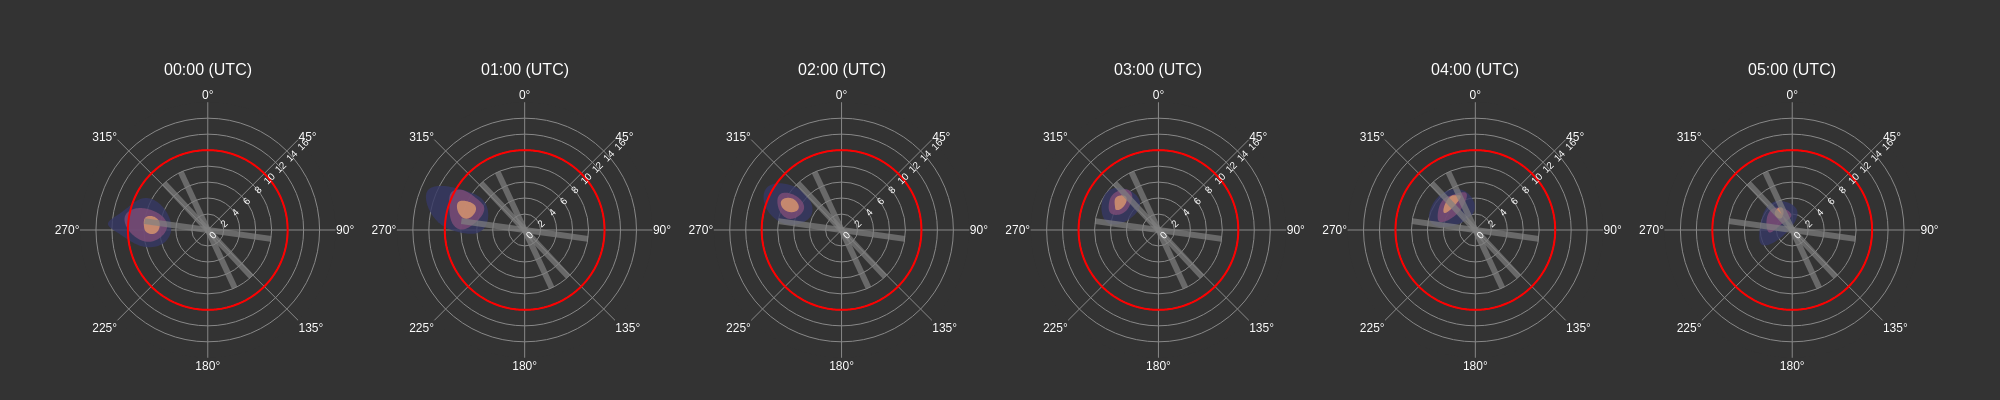

In [136]:
chart.show(renderer="png", width=2000, height=400)